In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import datasets, transforms

In [0]:
!pip install tensorboardx

     |████████████████████████████████| 194kB 2.8MB/s 


In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(
        root=out_dir, train=True, transform=compose, download=True
    )

# Load data
data = mnist_data()# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Num batches
num_batches = len(data_loader)

In [0]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 272)
        self.fc3 = nn.Linear(272, 136)
        self.op = nn.Linear(136, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.op(x))
        return x

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(136, 272)
        self.fc2 = nn.Linear(272, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.op = nn.Linear(1024, 784)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.op(x))
        return x


discriminator = Discriminator()
generator = Generator()

d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)

loss = nn.BCELoss()

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 136))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
def train_discriminator(optimizer, real_data, fake_date):
    N = real_data.size(0)
    #reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error


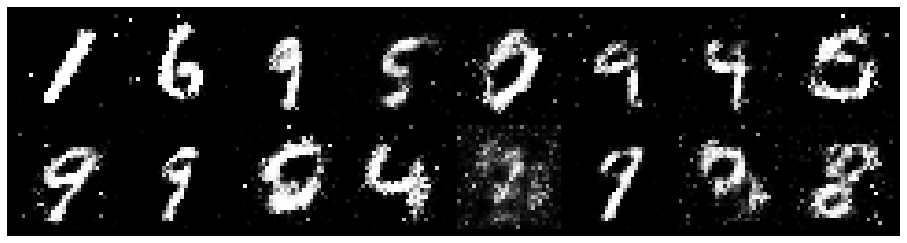

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 0.8694, Generator Loss: 1.3789
D(x): 0.6987, D(G(z)): 0.3009


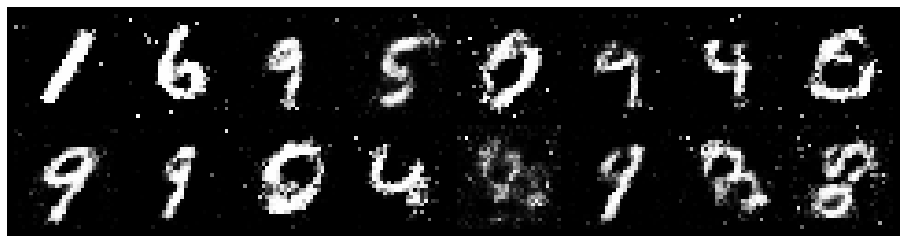

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 0.9375, Generator Loss: 1.6059
D(x): 0.6601, D(G(z)): 0.2732


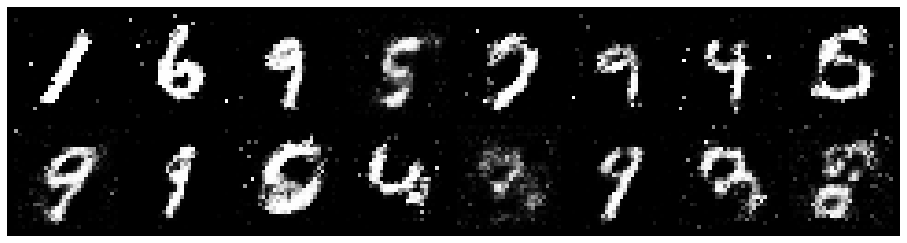

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 1.0295, Generator Loss: 1.3029
D(x): 0.7176, D(G(z)): 0.4023


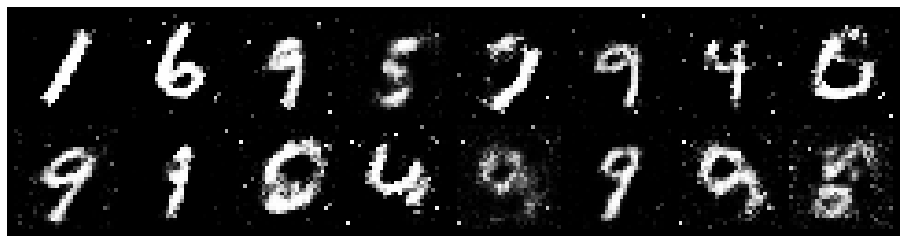

Epoch: [1/50], Batch Num: [300/600]
Discriminator Loss: 0.9672, Generator Loss: 1.4577
D(x): 0.6702, D(G(z)): 0.3113


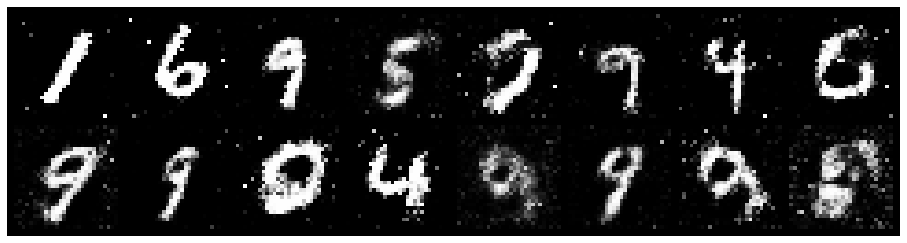

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 0.9443, Generator Loss: 1.5643
D(x): 0.6552, D(G(z)): 0.2840


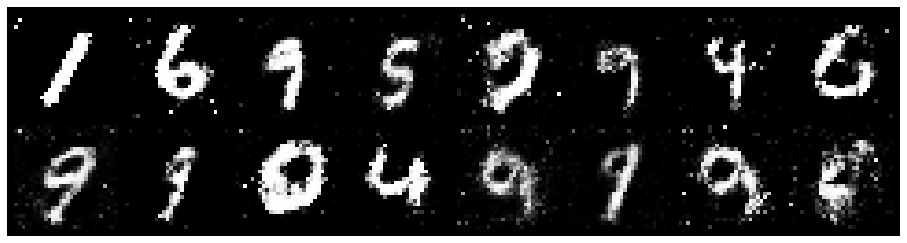

Epoch: [2/50], Batch Num: [300/600]
Discriminator Loss: 0.8915, Generator Loss: 1.6018
D(x): 0.6662, D(G(z)): 0.2546


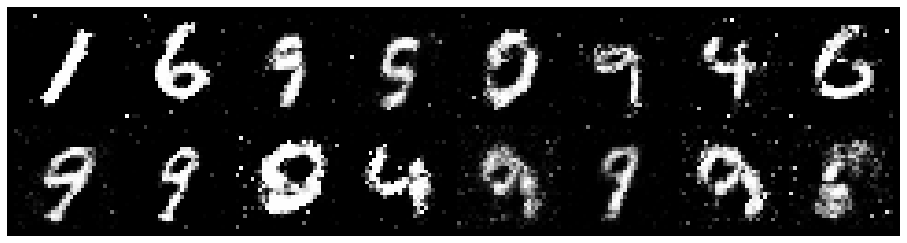

Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.7616, Generator Loss: 1.8688
D(x): 0.6987, D(G(z)): 0.2080


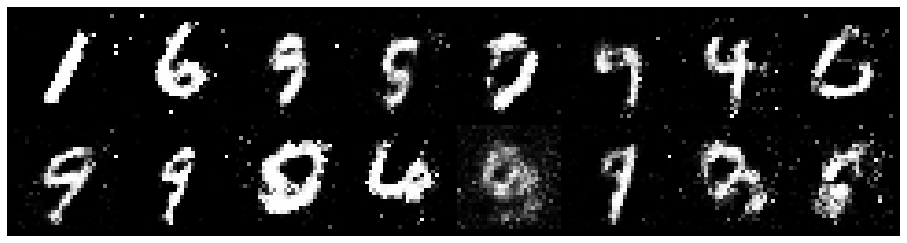

Epoch: [3/50], Batch Num: [300/600]
Discriminator Loss: 0.9868, Generator Loss: 1.5053
D(x): 0.7045, D(G(z)): 0.3332


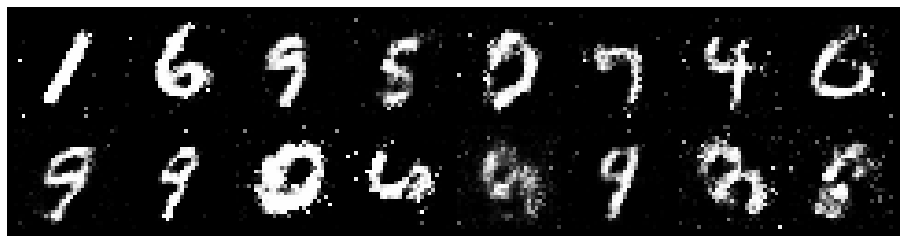

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 1.1374, Generator Loss: 1.3105
D(x): 0.6295, D(G(z)): 0.3517


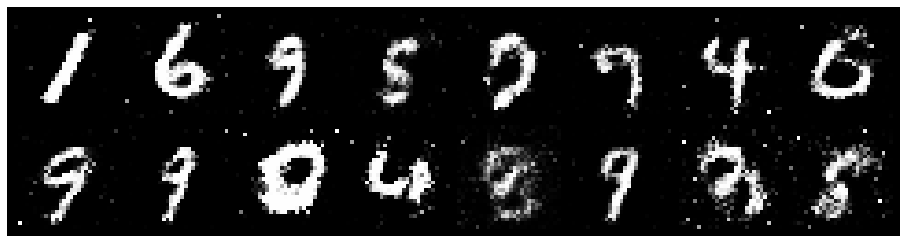

Epoch: [4/50], Batch Num: [300/600]
Discriminator Loss: 0.8509, Generator Loss: 1.4383
D(x): 0.7194, D(G(z)): 0.3015


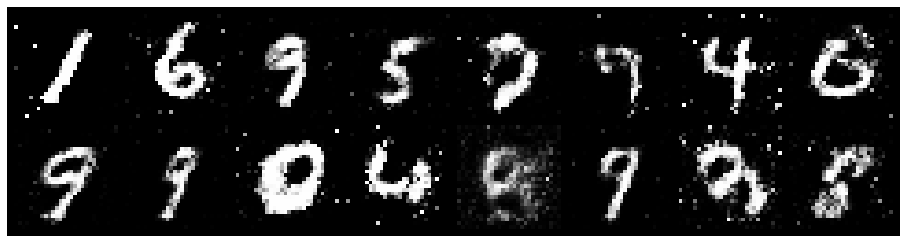

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.9530, Generator Loss: 1.2079
D(x): 0.7032, D(G(z)): 0.3546


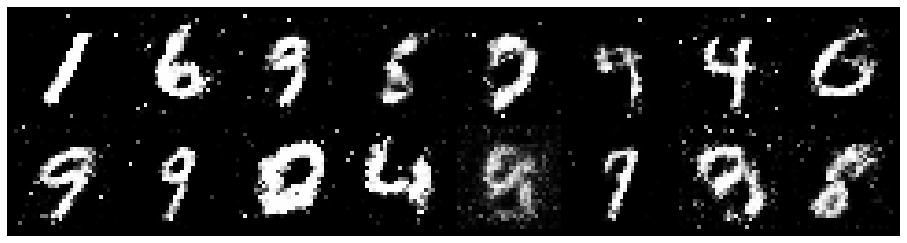

Epoch: [5/50], Batch Num: [300/600]
Discriminator Loss: 0.8686, Generator Loss: 1.4277
D(x): 0.7454, D(G(z)): 0.3281


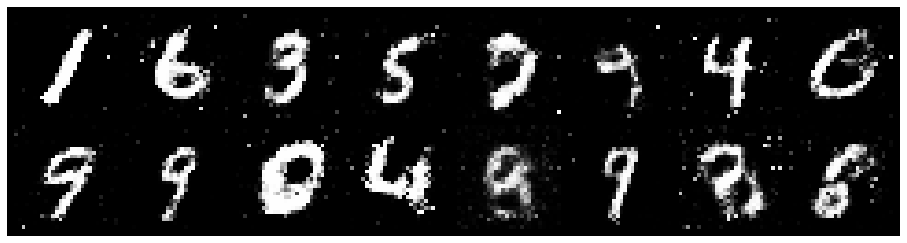

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.8199, Generator Loss: 1.5336
D(x): 0.7333, D(G(z)): 0.3166


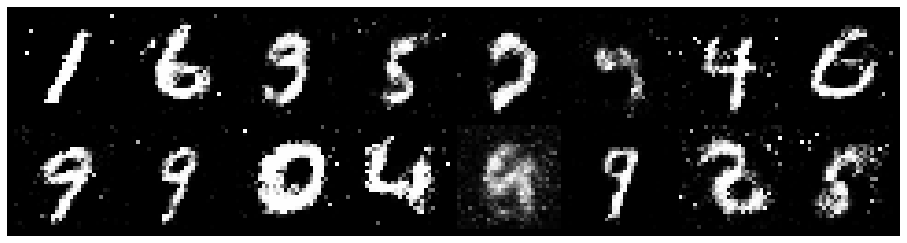

Epoch: [6/50], Batch Num: [300/600]
Discriminator Loss: 1.0064, Generator Loss: 1.3390
D(x): 0.6662, D(G(z)): 0.3384


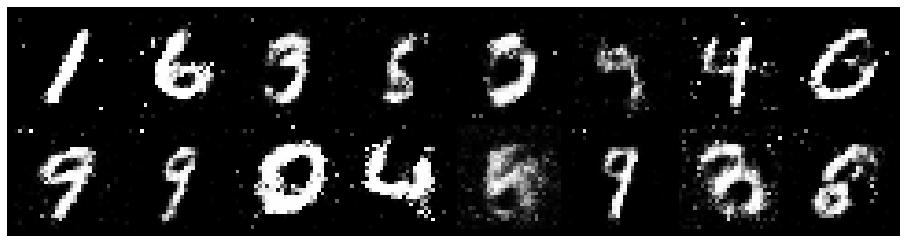

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 1.0293, Generator Loss: 1.2978
D(x): 0.6713, D(G(z)): 0.3527


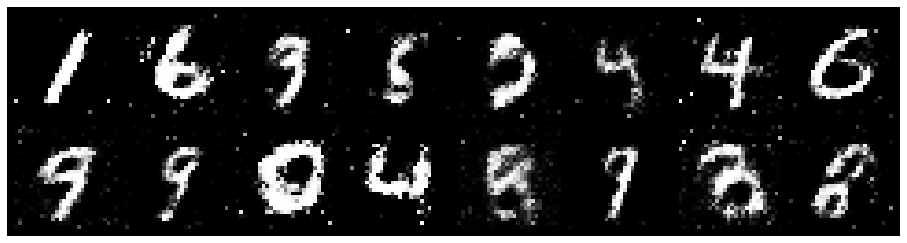

Epoch: [7/50], Batch Num: [300/600]
Discriminator Loss: 1.0569, Generator Loss: 1.4100
D(x): 0.6022, D(G(z)): 0.3070


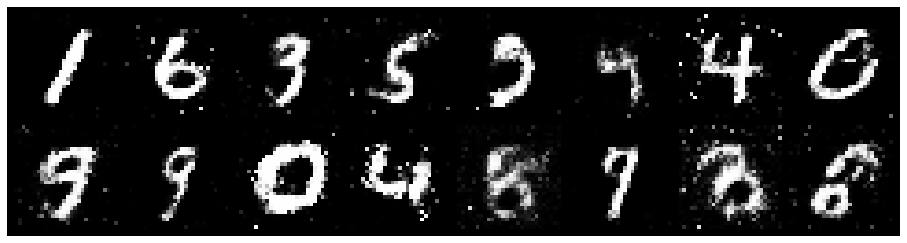

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 1.0889, Generator Loss: 1.3156
D(x): 0.6168, D(G(z)): 0.3173


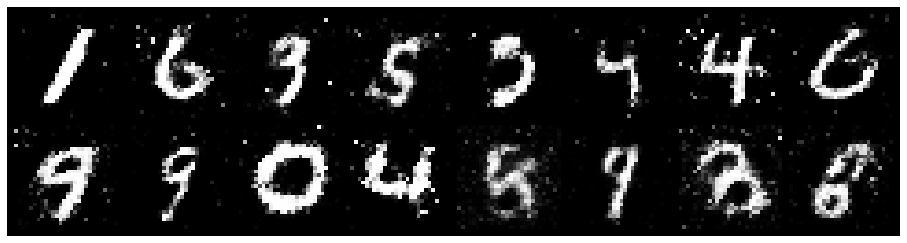

Epoch: [8/50], Batch Num: [300/600]
Discriminator Loss: 1.2598, Generator Loss: 1.0493
D(x): 0.5966, D(G(z)): 0.4137


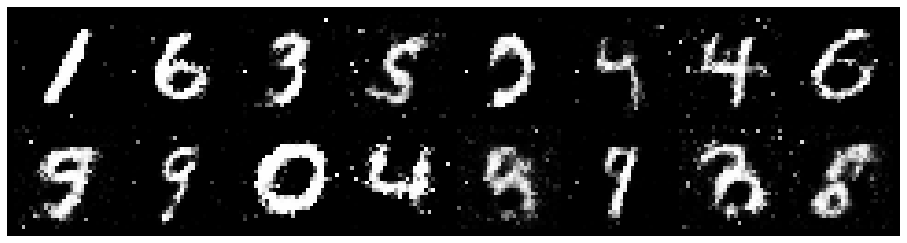

Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 1.1401, Generator Loss: 1.2676
D(x): 0.6887, D(G(z)): 0.4234


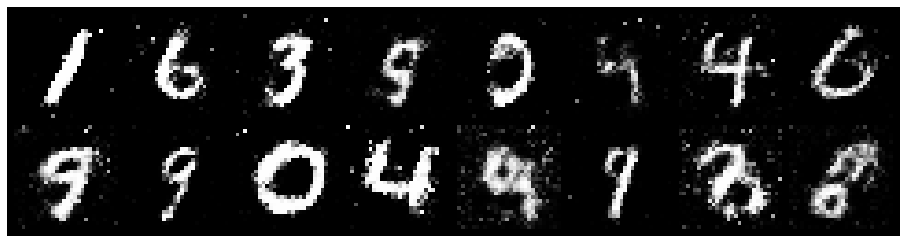

Epoch: [9/50], Batch Num: [300/600]
Discriminator Loss: 1.0708, Generator Loss: 1.4476
D(x): 0.6718, D(G(z)): 0.3762


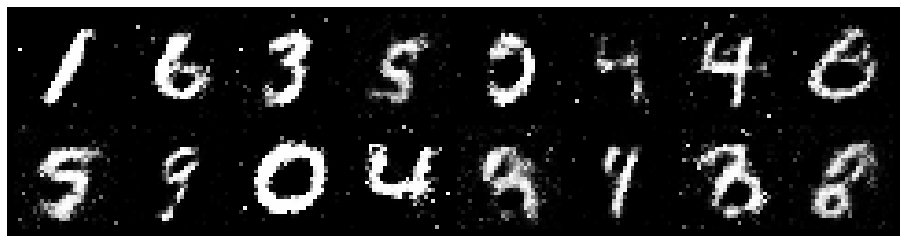

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 1.0480, Generator Loss: 1.3773
D(x): 0.6032, D(G(z)): 0.3236


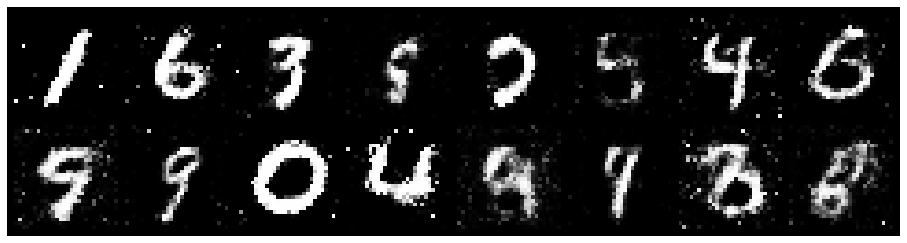

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 1.0479, Generator Loss: 1.2393
D(x): 0.6713, D(G(z)): 0.3577


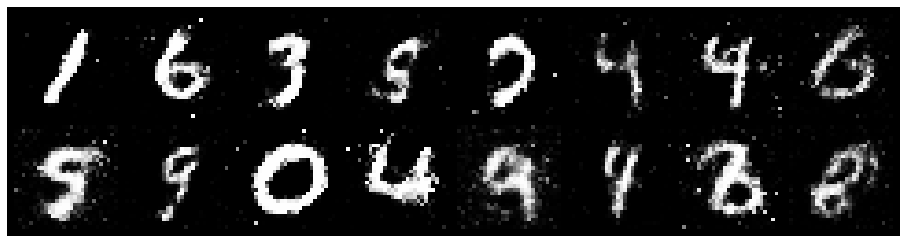

Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.9380, Generator Loss: 1.0573
D(x): 0.7476, D(G(z)): 0.3737


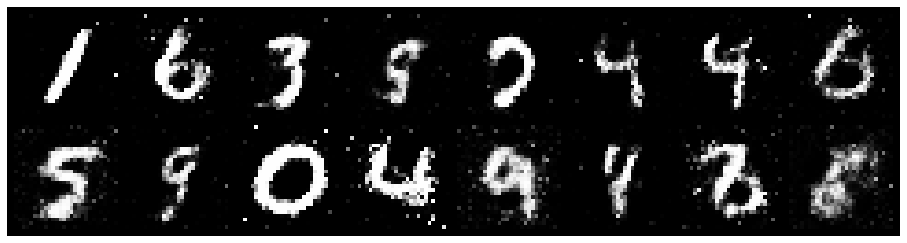

Epoch: [11/50], Batch Num: [300/600]
Discriminator Loss: 0.9768, Generator Loss: 1.2187
D(x): 0.6730, D(G(z)): 0.3476


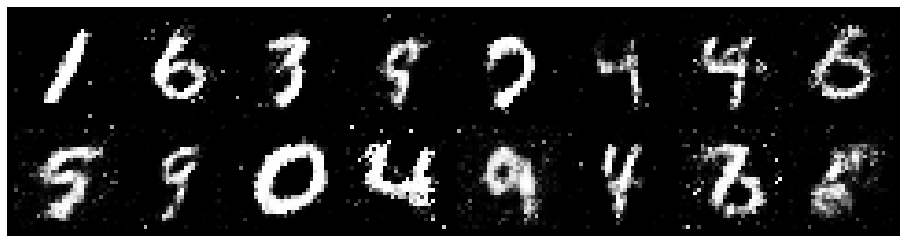

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.9537, Generator Loss: 1.3051
D(x): 0.6225, D(G(z)): 0.2784


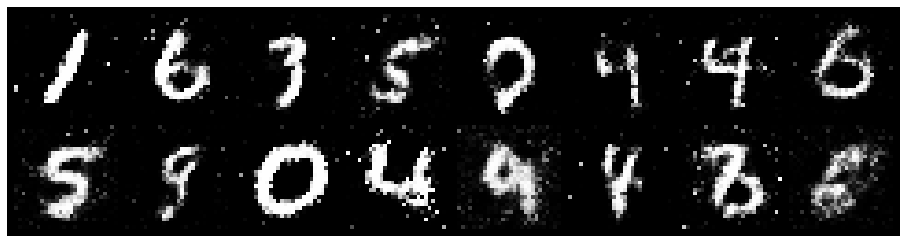

Epoch: [12/50], Batch Num: [300/600]
Discriminator Loss: 0.9306, Generator Loss: 1.3003
D(x): 0.6908, D(G(z)): 0.3383


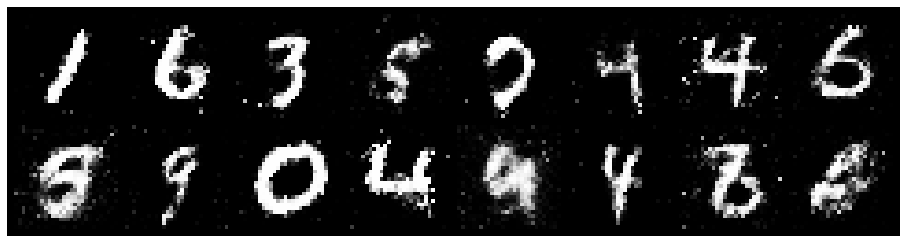

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 1.0330, Generator Loss: 1.1285
D(x): 0.7073, D(G(z)): 0.4221


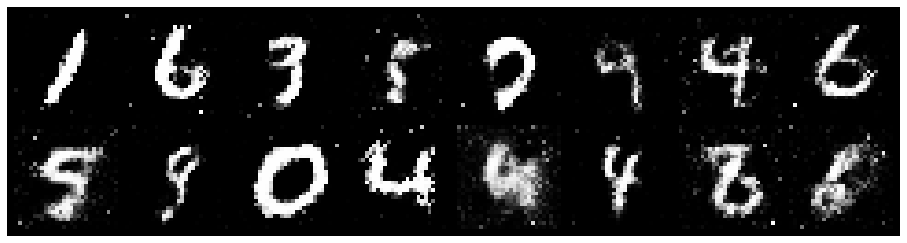

Epoch: [13/50], Batch Num: [300/600]
Discriminator Loss: 0.9517, Generator Loss: 1.3098
D(x): 0.6684, D(G(z)): 0.3338


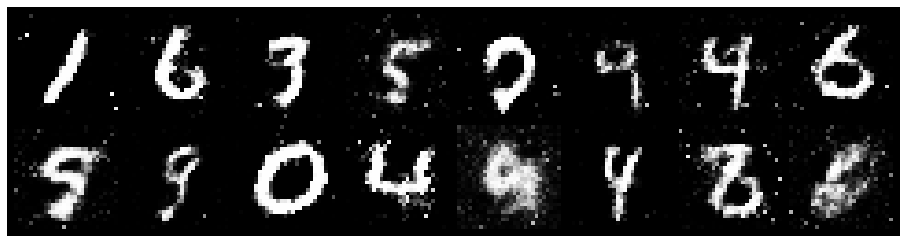

Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 1.0429, Generator Loss: 1.6288
D(x): 0.6246, D(G(z)): 0.3307


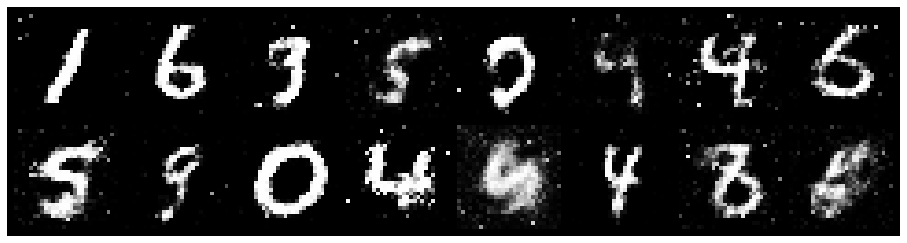

Epoch: [14/50], Batch Num: [300/600]
Discriminator Loss: 1.1643, Generator Loss: 1.0132
D(x): 0.6546, D(G(z)): 0.4226


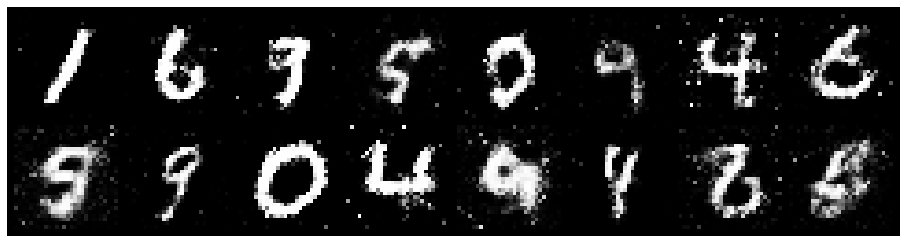

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 1.0241, Generator Loss: 1.2670
D(x): 0.6433, D(G(z)): 0.3503


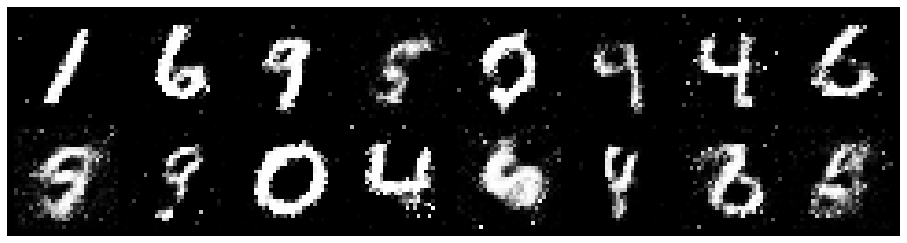

Epoch: [15/50], Batch Num: [300/600]
Discriminator Loss: 0.9668, Generator Loss: 1.2793
D(x): 0.7437, D(G(z)): 0.4115


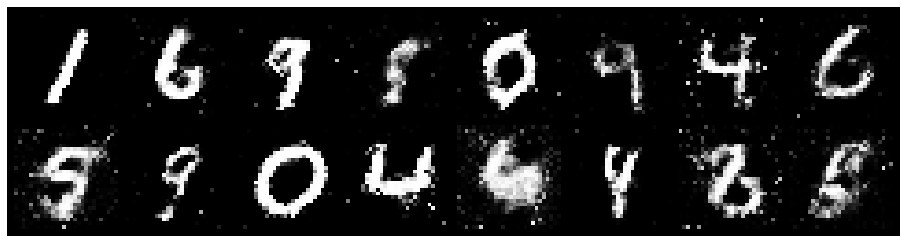

Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 1.1193, Generator Loss: 1.2791
D(x): 0.5844, D(G(z)): 0.3355


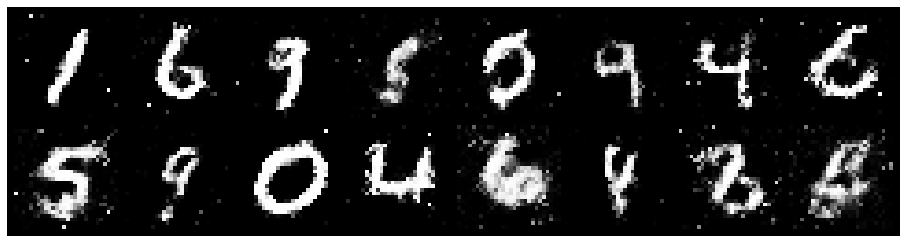

Epoch: [16/50], Batch Num: [300/600]
Discriminator Loss: 1.0446, Generator Loss: 1.2440
D(x): 0.6391, D(G(z)): 0.3660


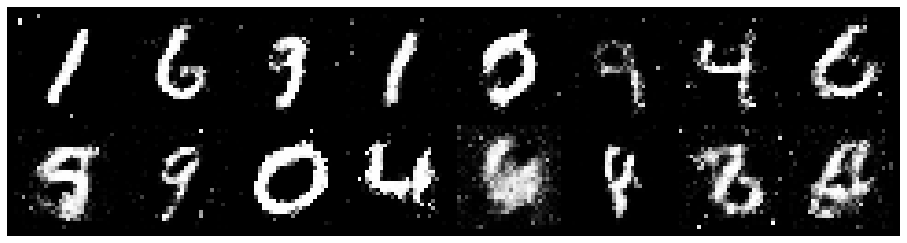

Epoch: [17/50], Batch Num: [0/600]
Discriminator Loss: 0.9789, Generator Loss: 1.1002
D(x): 0.7098, D(G(z)): 0.3793


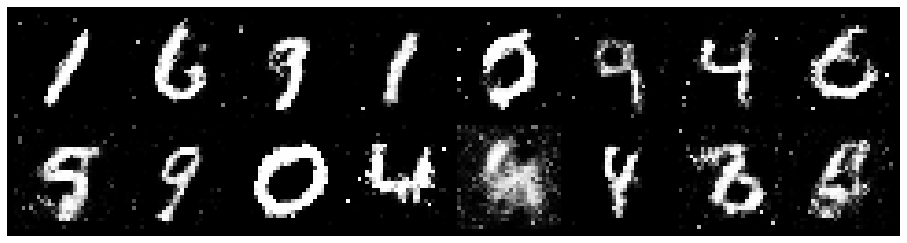

Epoch: [17/50], Batch Num: [300/600]
Discriminator Loss: 1.0780, Generator Loss: 1.1788
D(x): 0.6428, D(G(z)): 0.3590


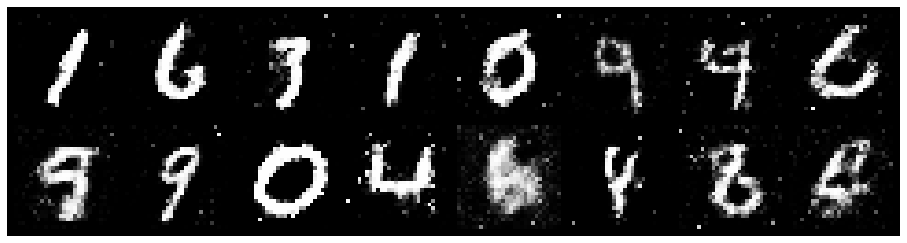

Epoch: [18/50], Batch Num: [0/600]
Discriminator Loss: 0.9060, Generator Loss: 1.4602
D(x): 0.7262, D(G(z)): 0.3462


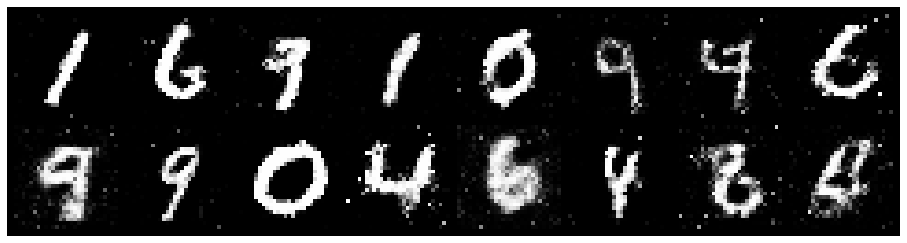

Epoch: [18/50], Batch Num: [300/600]
Discriminator Loss: 1.0024, Generator Loss: 1.5802
D(x): 0.6137, D(G(z)): 0.2936


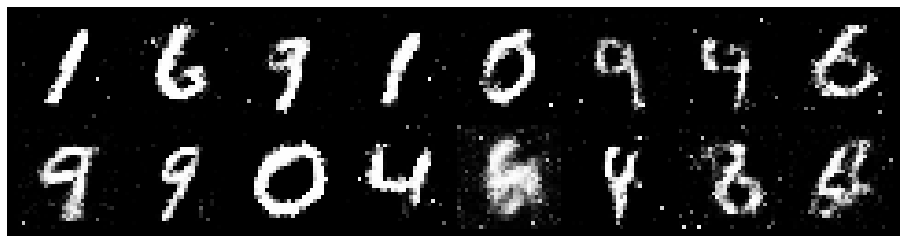

Epoch: [19/50], Batch Num: [0/600]
Discriminator Loss: 1.2981, Generator Loss: 1.3776
D(x): 0.5606, D(G(z)): 0.3692


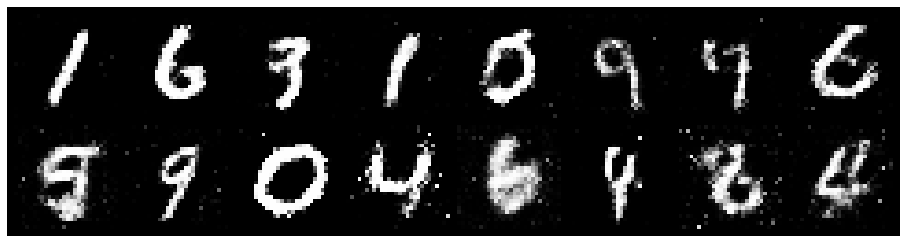

Epoch: [19/50], Batch Num: [300/600]
Discriminator Loss: 0.9013, Generator Loss: 1.5024
D(x): 0.6969, D(G(z)): 0.3314


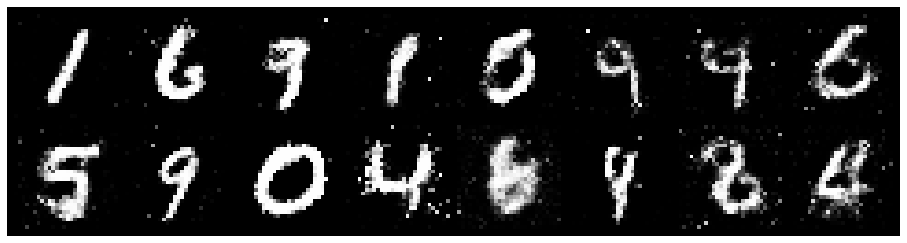

Epoch: [20/50], Batch Num: [0/600]
Discriminator Loss: 1.0440, Generator Loss: 1.1550
D(x): 0.6715, D(G(z)): 0.3869


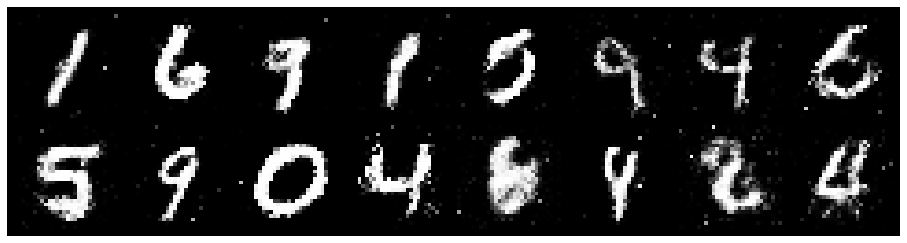

Epoch: [20/50], Batch Num: [300/600]
Discriminator Loss: 1.0002, Generator Loss: 1.4770
D(x): 0.6167, D(G(z)): 0.3207


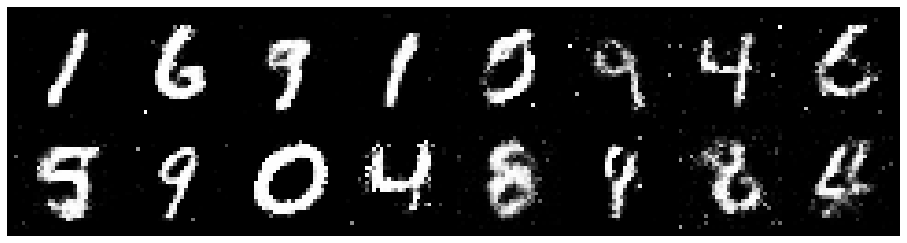

Epoch: [21/50], Batch Num: [0/600]
Discriminator Loss: 1.1323, Generator Loss: 1.2666
D(x): 0.6022, D(G(z)): 0.3632


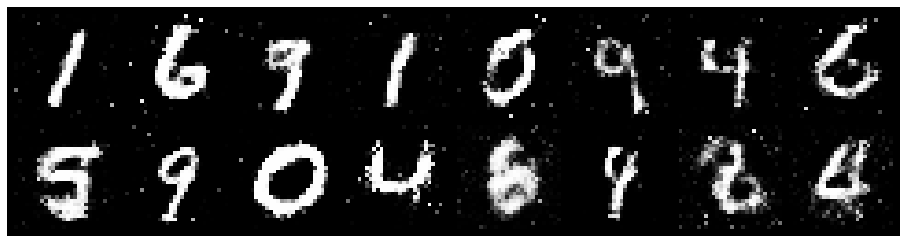

Epoch: [21/50], Batch Num: [300/600]
Discriminator Loss: 1.0511, Generator Loss: 1.3066
D(x): 0.6188, D(G(z)): 0.3306


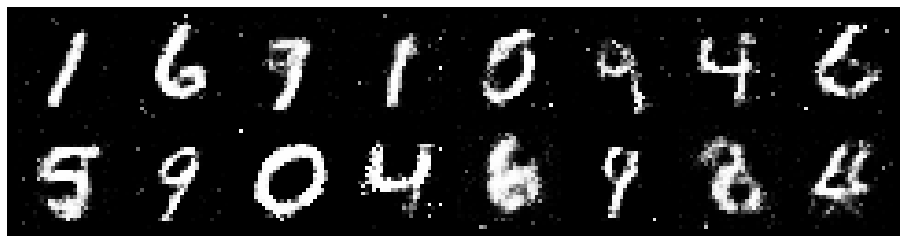

Epoch: [22/50], Batch Num: [0/600]
Discriminator Loss: 1.0710, Generator Loss: 1.0819
D(x): 0.5952, D(G(z)): 0.3290


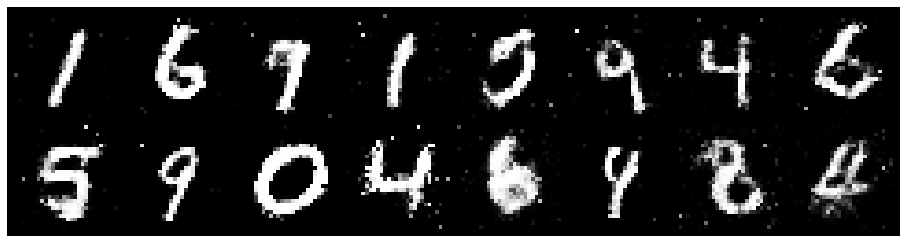

Epoch: [22/50], Batch Num: [300/600]
Discriminator Loss: 1.1549, Generator Loss: 1.2381
D(x): 0.6206, D(G(z)): 0.3604


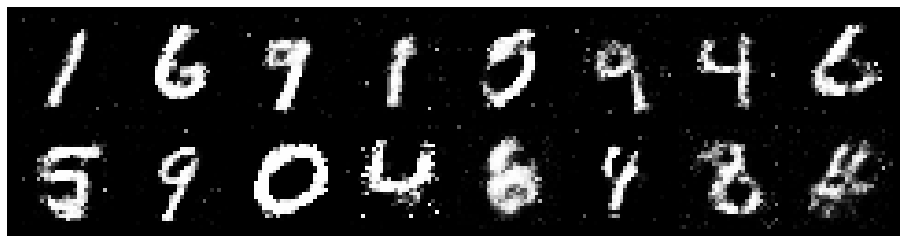

Epoch: [23/50], Batch Num: [0/600]
Discriminator Loss: 0.9973, Generator Loss: 1.0907
D(x): 0.6882, D(G(z)): 0.3879


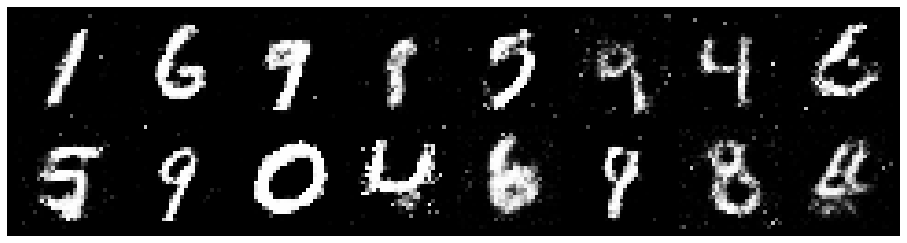

Epoch: [23/50], Batch Num: [300/600]
Discriminator Loss: 1.3501, Generator Loss: 1.2209
D(x): 0.5452, D(G(z)): 0.3981


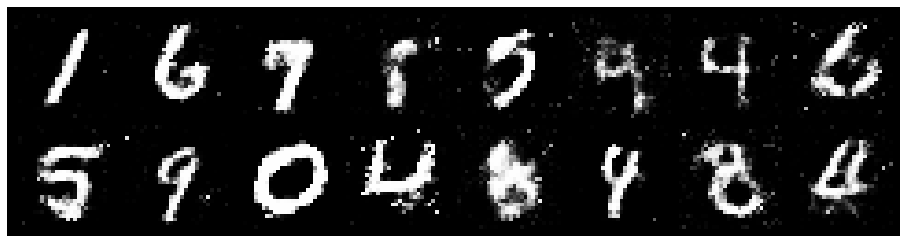

Epoch: [24/50], Batch Num: [0/600]
Discriminator Loss: 0.8762, Generator Loss: 1.2515
D(x): 0.6854, D(G(z)): 0.3076


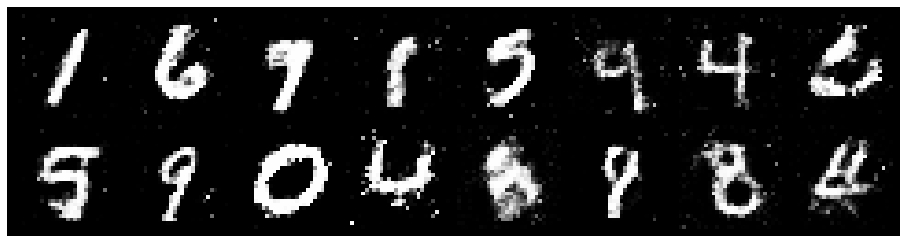

Epoch: [24/50], Batch Num: [300/600]
Discriminator Loss: 0.9775, Generator Loss: 1.2941
D(x): 0.6607, D(G(z)): 0.3508


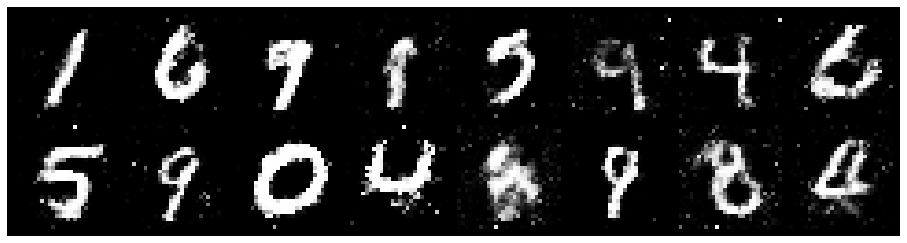

Epoch: [25/50], Batch Num: [0/600]
Discriminator Loss: 1.0509, Generator Loss: 1.0796
D(x): 0.6461, D(G(z)): 0.3760


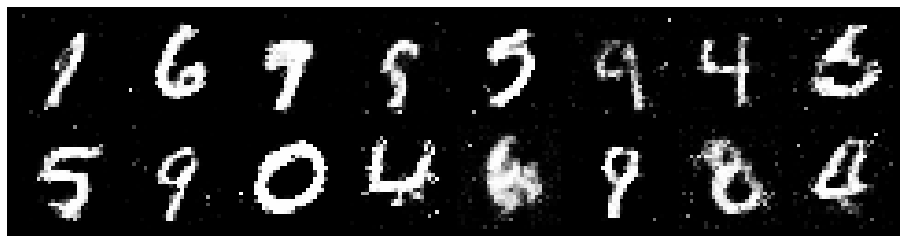

Epoch: [25/50], Batch Num: [300/600]
Discriminator Loss: 0.9838, Generator Loss: 1.2558
D(x): 0.6252, D(G(z)): 0.3047


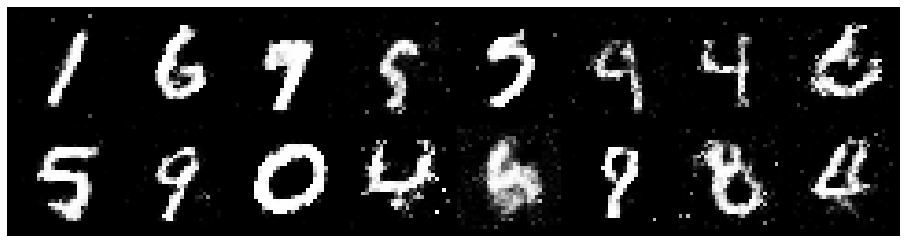

Epoch: [26/50], Batch Num: [0/600]
Discriminator Loss: 0.9747, Generator Loss: 1.2637
D(x): 0.6615, D(G(z)): 0.3338


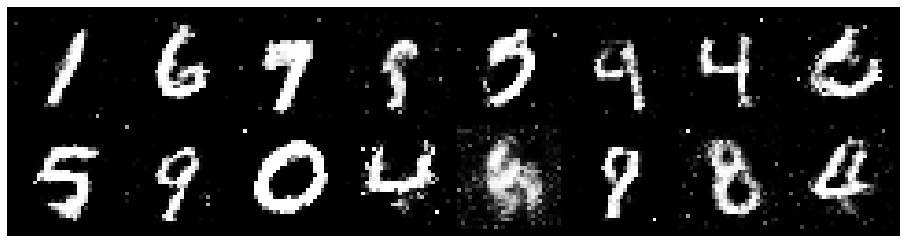

Epoch: [26/50], Batch Num: [300/600]
Discriminator Loss: 1.1201, Generator Loss: 1.2282
D(x): 0.6113, D(G(z)): 0.3748


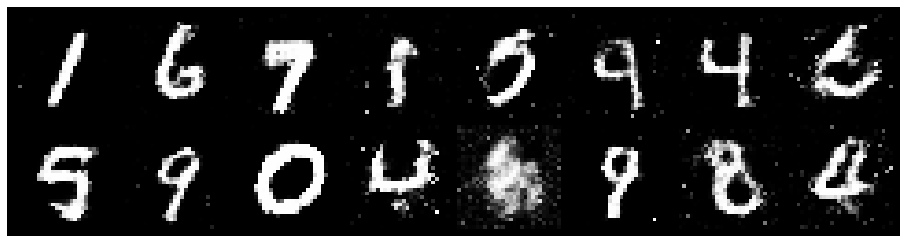

Epoch: [27/50], Batch Num: [0/600]
Discriminator Loss: 1.0239, Generator Loss: 0.9388
D(x): 0.6873, D(G(z)): 0.4021


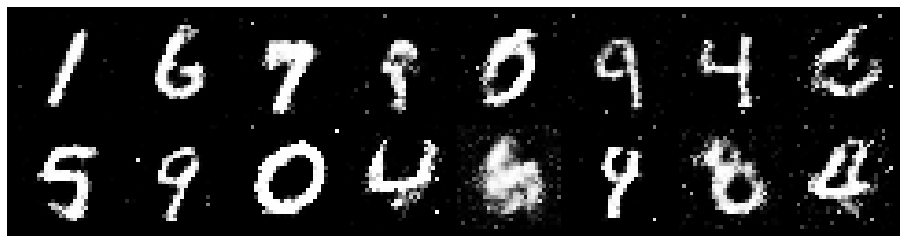

Epoch: [27/50], Batch Num: [300/600]
Discriminator Loss: 0.9237, Generator Loss: 1.1687
D(x): 0.7079, D(G(z)): 0.3635


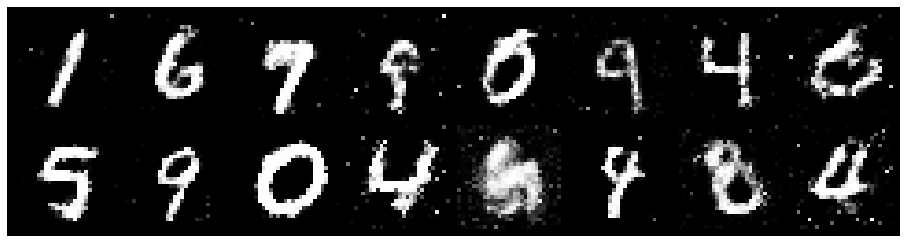

Epoch: [28/50], Batch Num: [0/600]
Discriminator Loss: 1.2410, Generator Loss: 1.1970
D(x): 0.5854, D(G(z)): 0.4069


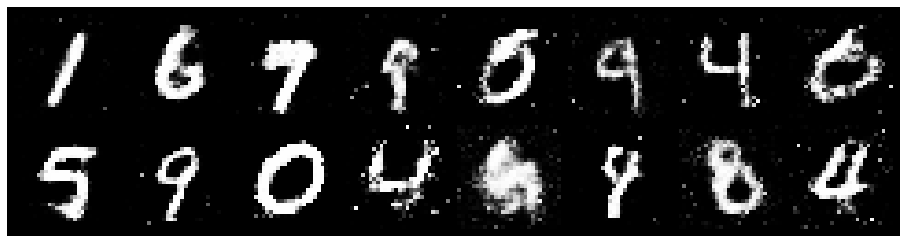

Epoch: [28/50], Batch Num: [300/600]
Discriminator Loss: 1.1482, Generator Loss: 1.0627
D(x): 0.6047, D(G(z)): 0.3807


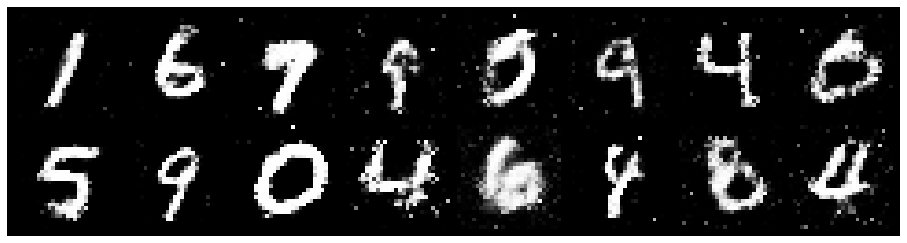

Epoch: [29/50], Batch Num: [0/600]
Discriminator Loss: 1.0629, Generator Loss: 1.1536
D(x): 0.6890, D(G(z)): 0.4139


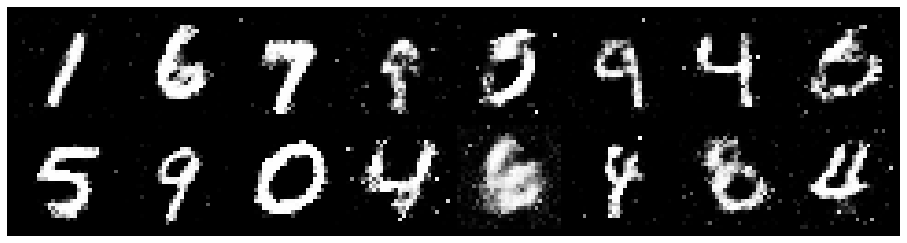

Epoch: [29/50], Batch Num: [300/600]
Discriminator Loss: 0.8803, Generator Loss: 1.1860
D(x): 0.7351, D(G(z)): 0.3662


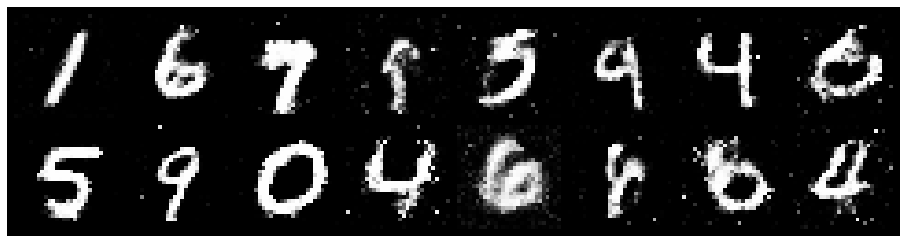

Epoch: [30/50], Batch Num: [0/600]
Discriminator Loss: 1.1634, Generator Loss: 1.1692
D(x): 0.6170, D(G(z)): 0.3754


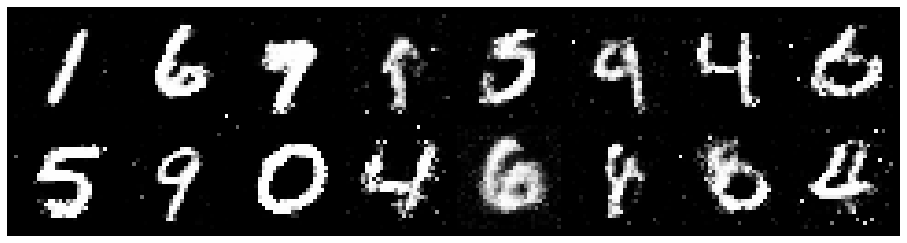

Epoch: [30/50], Batch Num: [300/600]
Discriminator Loss: 1.0204, Generator Loss: 1.3146
D(x): 0.6282, D(G(z)): 0.3314


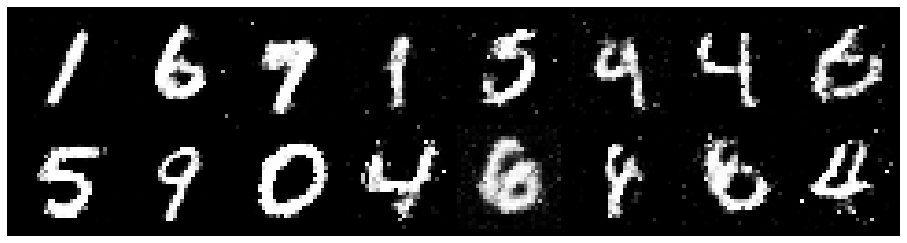

Epoch: [31/50], Batch Num: [0/600]
Discriminator Loss: 1.2042, Generator Loss: 1.2828
D(x): 0.5797, D(G(z)): 0.3814


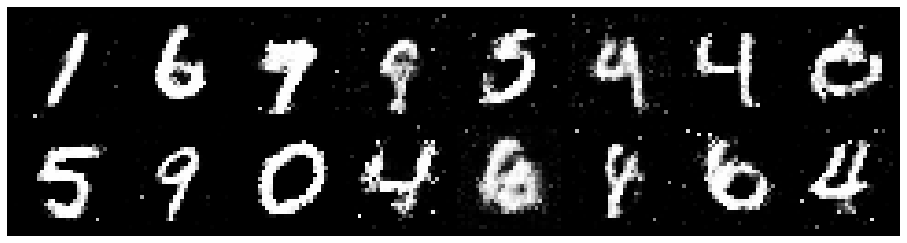

Epoch: [31/50], Batch Num: [300/600]
Discriminator Loss: 1.0944, Generator Loss: 1.1490
D(x): 0.6042, D(G(z)): 0.3497


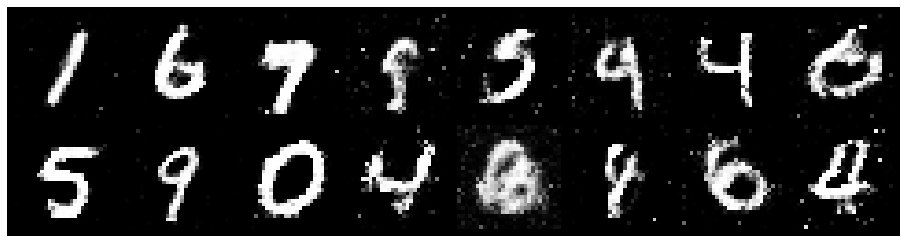

Epoch: [32/50], Batch Num: [0/600]
Discriminator Loss: 1.0806, Generator Loss: 1.0820
D(x): 0.6149, D(G(z)): 0.3554


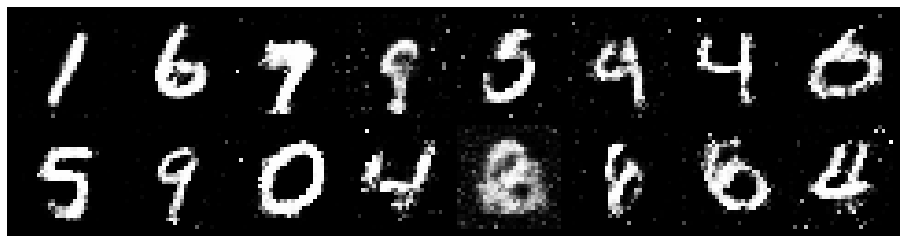

Epoch: [32/50], Batch Num: [300/600]
Discriminator Loss: 1.1888, Generator Loss: 1.2509
D(x): 0.5991, D(G(z)): 0.3828


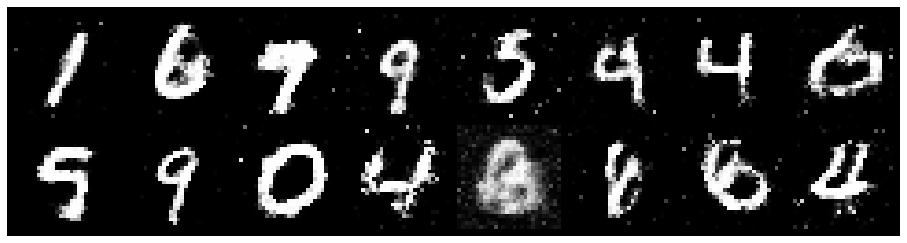

Epoch: [33/50], Batch Num: [0/600]
Discriminator Loss: 0.9639, Generator Loss: 1.1846
D(x): 0.6554, D(G(z)): 0.3461


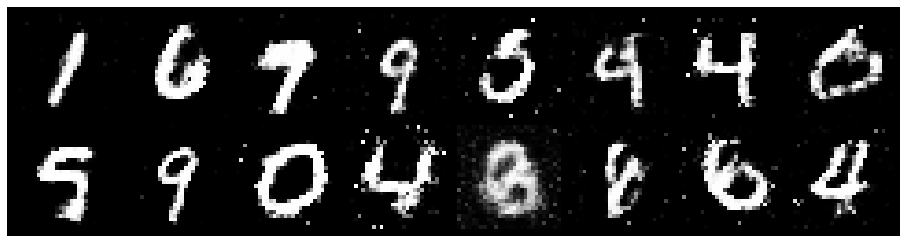

Epoch: [33/50], Batch Num: [300/600]
Discriminator Loss: 0.9760, Generator Loss: 1.3486
D(x): 0.6448, D(G(z)): 0.3423


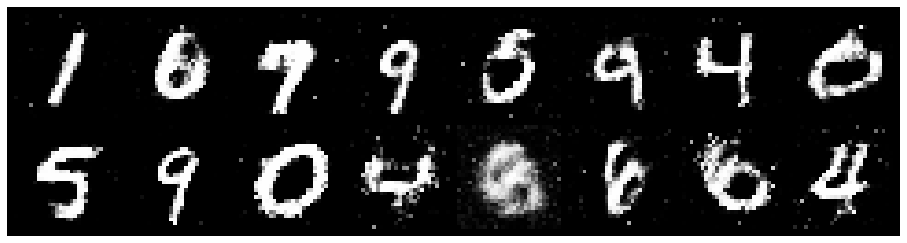

Epoch: [34/50], Batch Num: [0/600]
Discriminator Loss: 1.0033, Generator Loss: 1.0629
D(x): 0.7051, D(G(z)): 0.3904


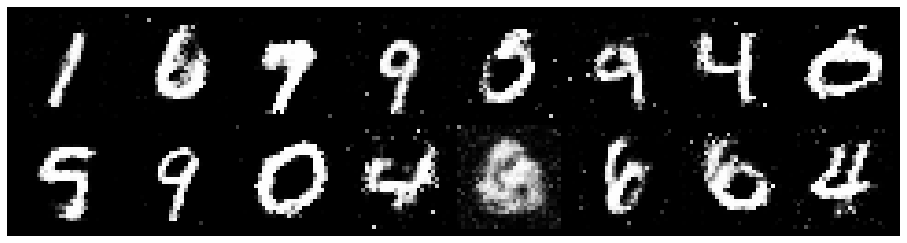

Epoch: [34/50], Batch Num: [300/600]
Discriminator Loss: 1.0896, Generator Loss: 1.1602
D(x): 0.6553, D(G(z)): 0.3943


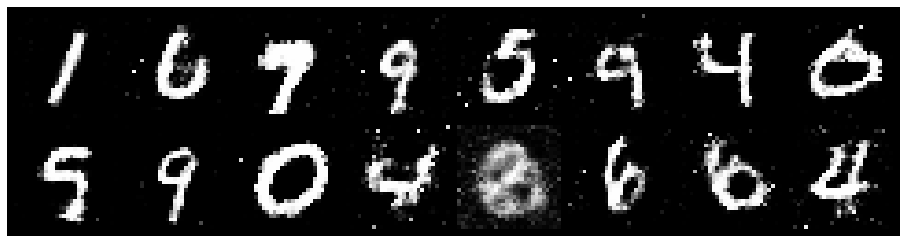

Epoch: [35/50], Batch Num: [0/600]
Discriminator Loss: 1.1525, Generator Loss: 1.3468
D(x): 0.6338, D(G(z)): 0.3893


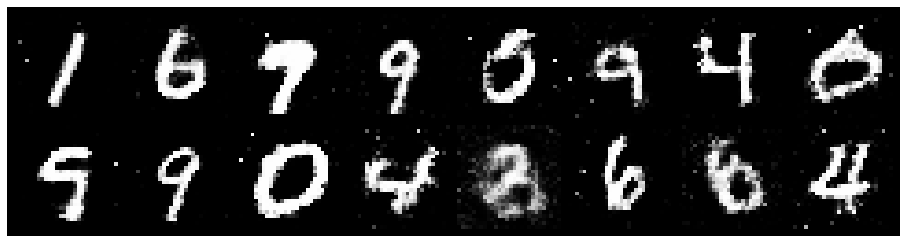

Epoch: [35/50], Batch Num: [300/600]
Discriminator Loss: 1.1944, Generator Loss: 0.9650
D(x): 0.6082, D(G(z)): 0.3944


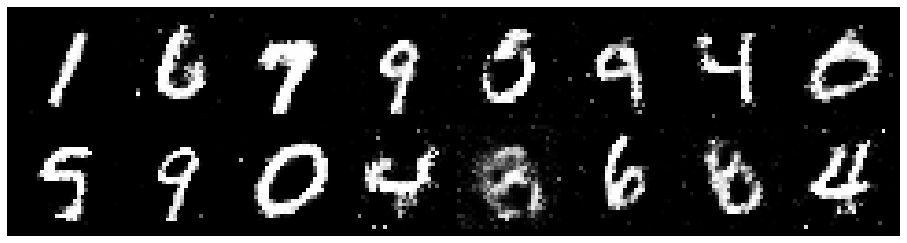

Epoch: [36/50], Batch Num: [0/600]
Discriminator Loss: 1.1011, Generator Loss: 1.2805
D(x): 0.5804, D(G(z)): 0.3251


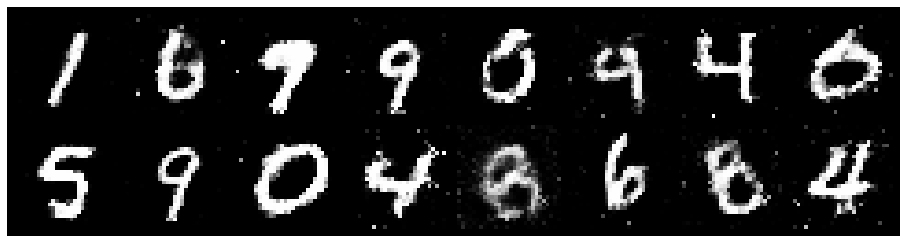

Epoch: [36/50], Batch Num: [300/600]
Discriminator Loss: 0.9741, Generator Loss: 1.3623
D(x): 0.6732, D(G(z)): 0.3460


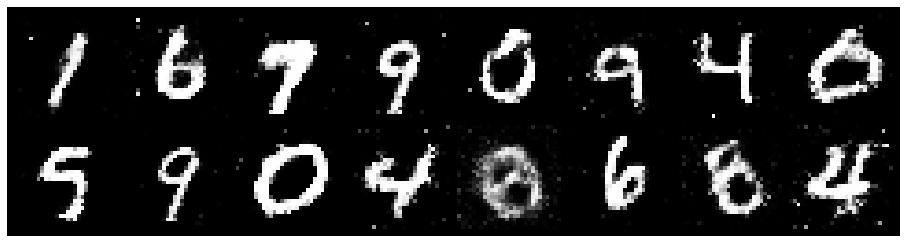

Epoch: [37/50], Batch Num: [0/600]
Discriminator Loss: 1.2323, Generator Loss: 1.0810
D(x): 0.6058, D(G(z)): 0.4145


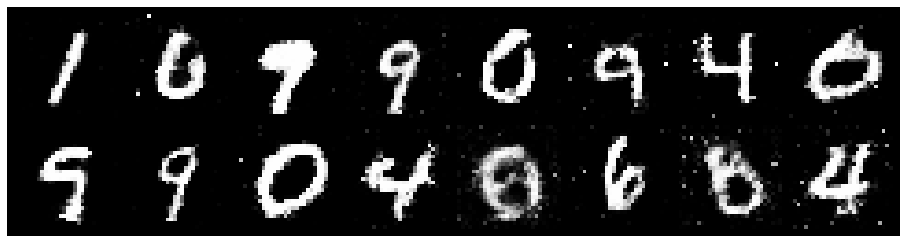

Epoch: [37/50], Batch Num: [300/600]
Discriminator Loss: 1.0269, Generator Loss: 1.0770
D(x): 0.6746, D(G(z)): 0.3877


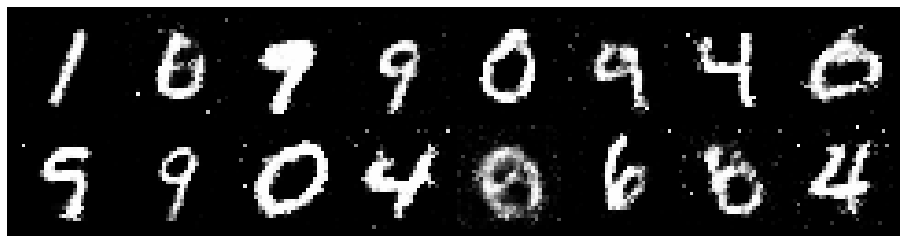

Epoch: [38/50], Batch Num: [0/600]
Discriminator Loss: 1.0107, Generator Loss: 1.1211
D(x): 0.6310, D(G(z)): 0.3394


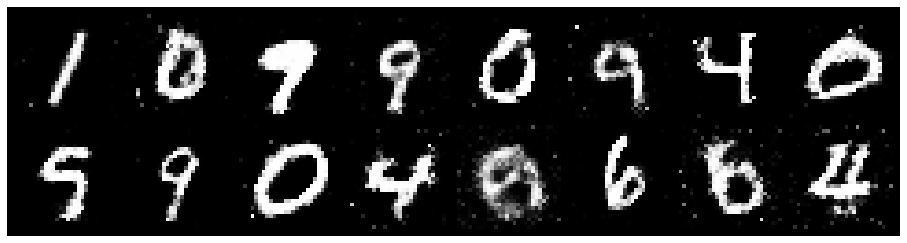

Epoch: [38/50], Batch Num: [300/600]
Discriminator Loss: 1.0194, Generator Loss: 1.0275
D(x): 0.6815, D(G(z)): 0.3970


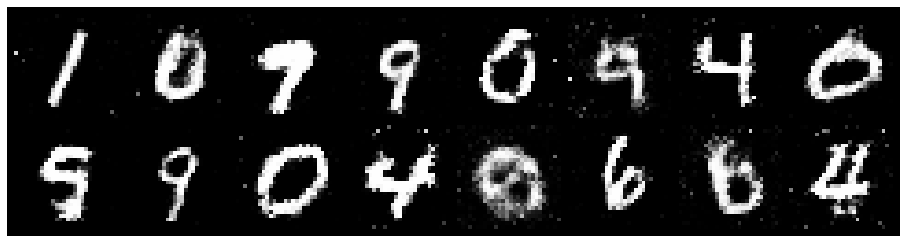

Epoch: [39/50], Batch Num: [0/600]
Discriminator Loss: 1.1290, Generator Loss: 1.0994
D(x): 0.6400, D(G(z)): 0.3908


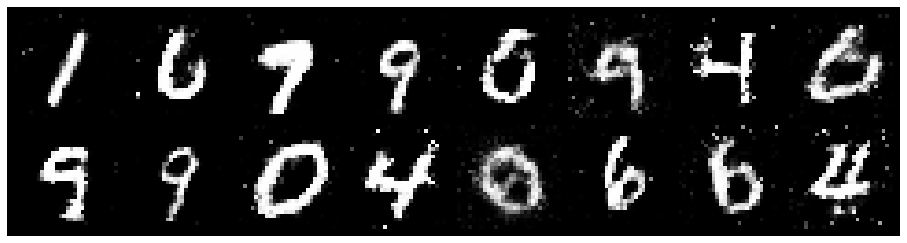

Epoch: [39/50], Batch Num: [300/600]
Discriminator Loss: 1.2034, Generator Loss: 1.1615
D(x): 0.5538, D(G(z)): 0.3454


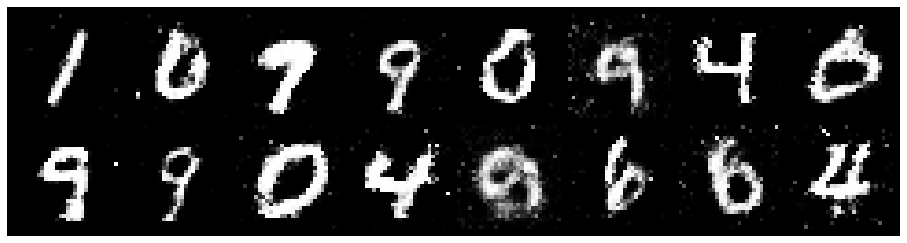

Epoch: [40/50], Batch Num: [0/600]
Discriminator Loss: 1.0909, Generator Loss: 1.1063
D(x): 0.6155, D(G(z)): 0.3685


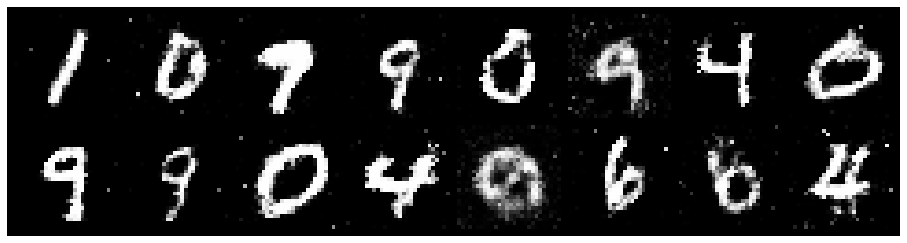

Epoch: [40/50], Batch Num: [300/600]
Discriminator Loss: 1.0620, Generator Loss: 1.3557
D(x): 0.6106, D(G(z)): 0.3519


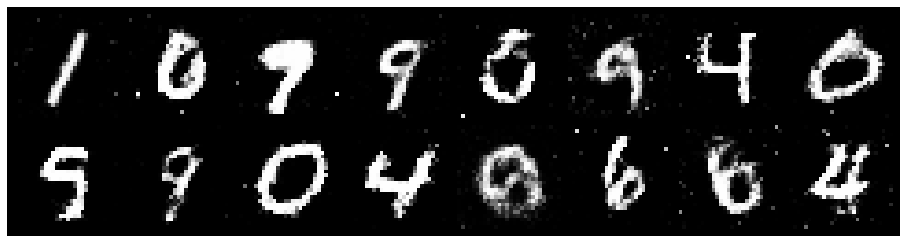

Epoch: [41/50], Batch Num: [0/600]
Discriminator Loss: 1.0896, Generator Loss: 0.9692
D(x): 0.6336, D(G(z)): 0.3864


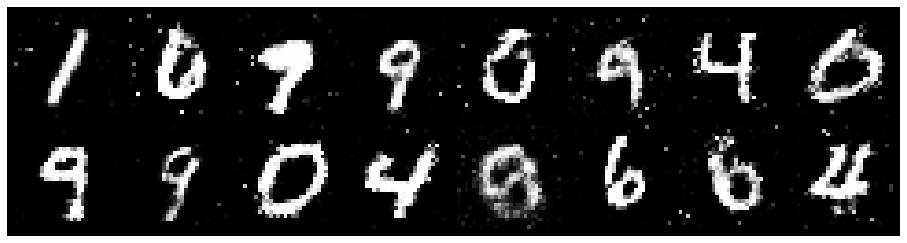

Epoch: [41/50], Batch Num: [300/600]
Discriminator Loss: 1.0523, Generator Loss: 1.1420
D(x): 0.6824, D(G(z)): 0.4020


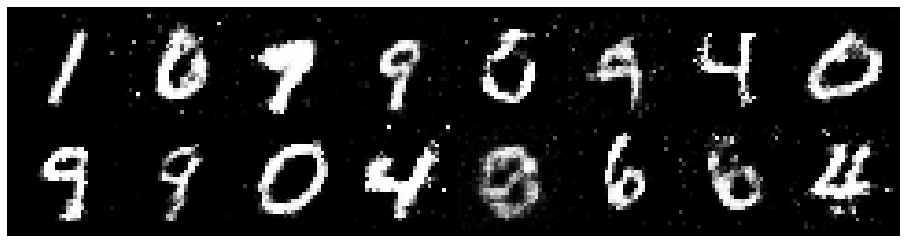

Epoch: [42/50], Batch Num: [0/600]
Discriminator Loss: 0.9384, Generator Loss: 1.2817
D(x): 0.7210, D(G(z)): 0.3699


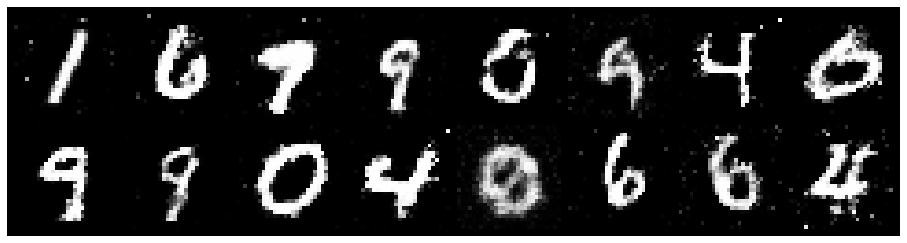

Epoch: [42/50], Batch Num: [300/600]
Discriminator Loss: 1.1415, Generator Loss: 1.0781
D(x): 0.6421, D(G(z)): 0.4098


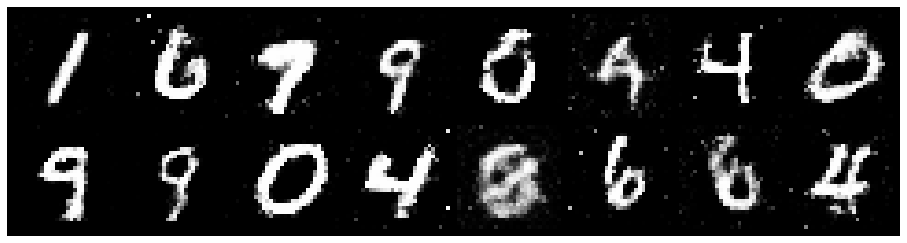

Epoch: [43/50], Batch Num: [0/600]
Discriminator Loss: 1.1765, Generator Loss: 1.0023
D(x): 0.6068, D(G(z)): 0.4018


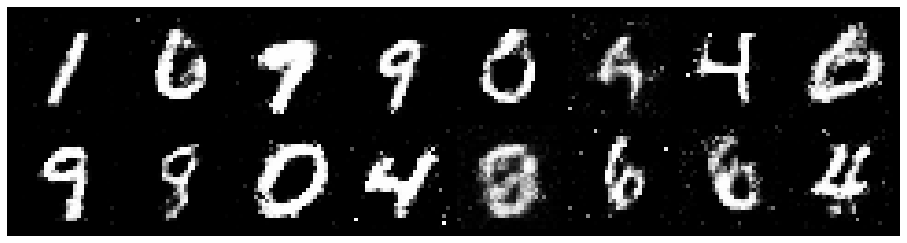

Epoch: [43/50], Batch Num: [300/600]
Discriminator Loss: 1.1270, Generator Loss: 1.1149
D(x): 0.6258, D(G(z)): 0.3656


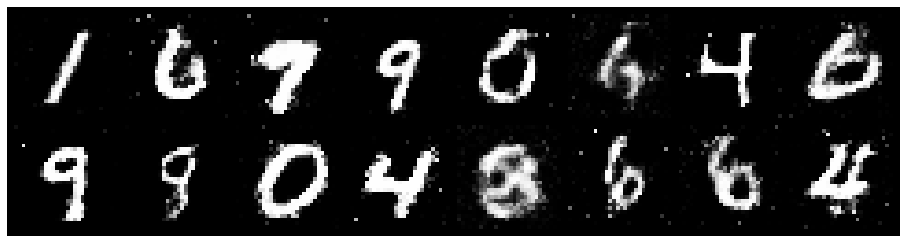

Epoch: [44/50], Batch Num: [0/600]
Discriminator Loss: 1.0961, Generator Loss: 1.0267
D(x): 0.6343, D(G(z)): 0.3899


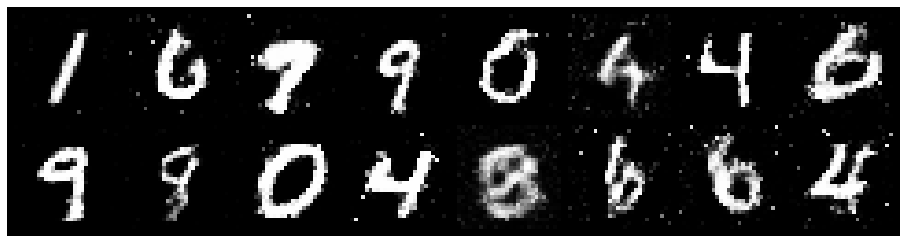

Epoch: [44/50], Batch Num: [300/600]
Discriminator Loss: 1.1109, Generator Loss: 0.9777
D(x): 0.6843, D(G(z)): 0.4446


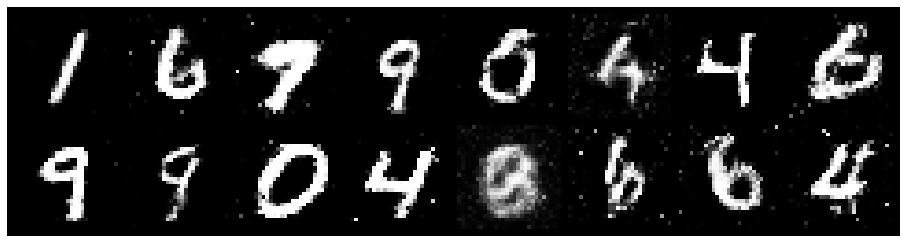

Epoch: [45/50], Batch Num: [0/600]
Discriminator Loss: 1.1786, Generator Loss: 1.0570
D(x): 0.6177, D(G(z)): 0.4025


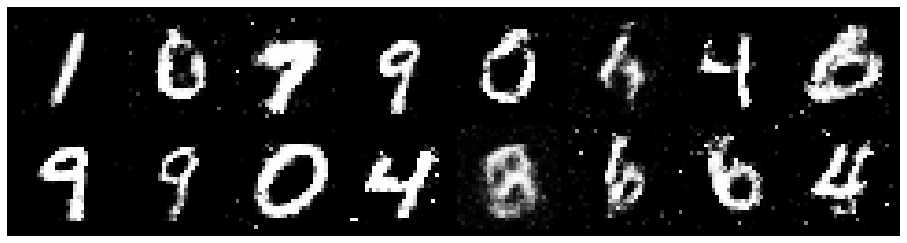

Epoch: [45/50], Batch Num: [300/600]
Discriminator Loss: 1.0359, Generator Loss: 1.2244
D(x): 0.6110, D(G(z)): 0.3383


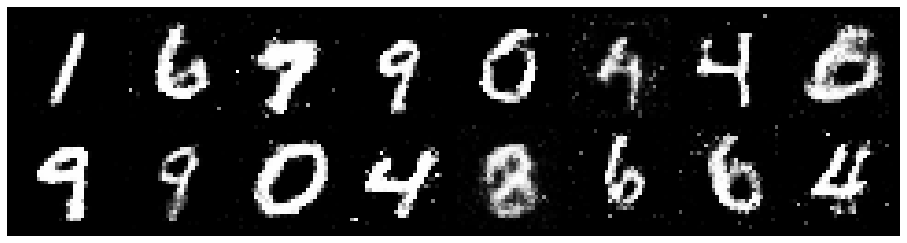

Epoch: [46/50], Batch Num: [0/600]
Discriminator Loss: 0.9572, Generator Loss: 0.9618
D(x): 0.6938, D(G(z)): 0.3698


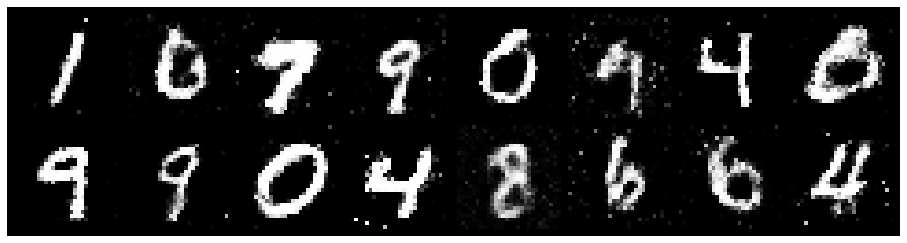

Epoch: [46/50], Batch Num: [300/600]
Discriminator Loss: 1.1111, Generator Loss: 1.1829
D(x): 0.6208, D(G(z)): 0.3768


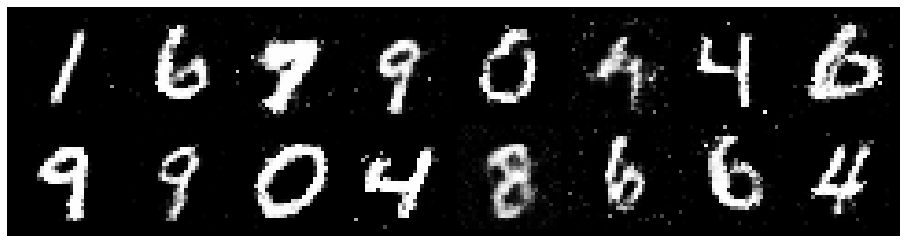

Epoch: [47/50], Batch Num: [0/600]
Discriminator Loss: 1.1638, Generator Loss: 1.2346
D(x): 0.5716, D(G(z)): 0.3461


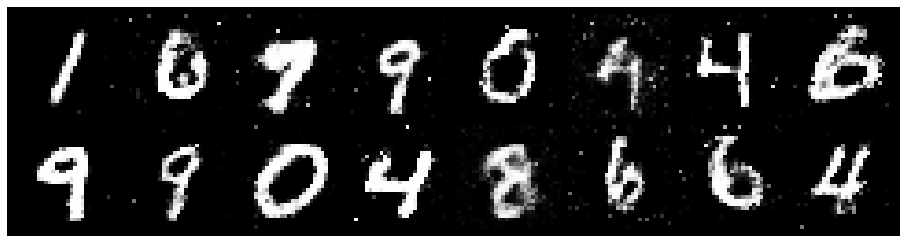

Epoch: [47/50], Batch Num: [300/600]
Discriminator Loss: 1.1658, Generator Loss: 1.0149
D(x): 0.6126, D(G(z)): 0.3948


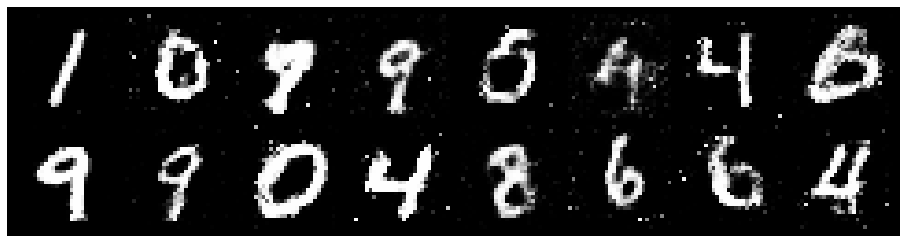

Epoch: [48/50], Batch Num: [0/600]
Discriminator Loss: 1.1338, Generator Loss: 1.0176
D(x): 0.5831, D(G(z)): 0.3565


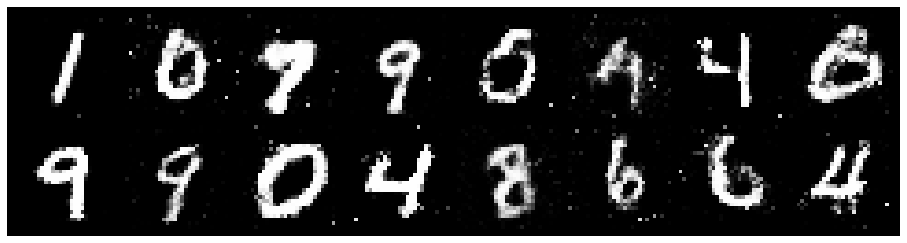

Epoch: [48/50], Batch Num: [300/600]
Discriminator Loss: 1.2383, Generator Loss: 1.0931
D(x): 0.6138, D(G(z)): 0.4392


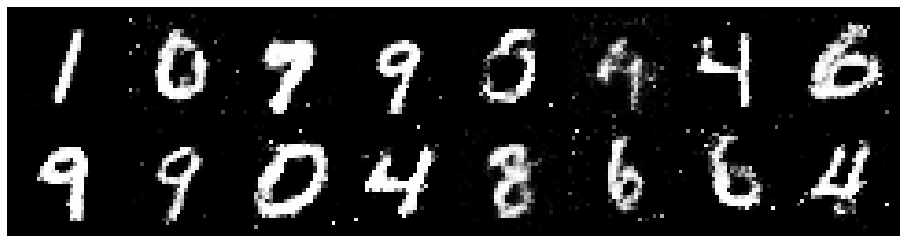

Epoch: [49/50], Batch Num: [0/600]
Discriminator Loss: 1.1496, Generator Loss: 1.1709
D(x): 0.6378, D(G(z)): 0.3753


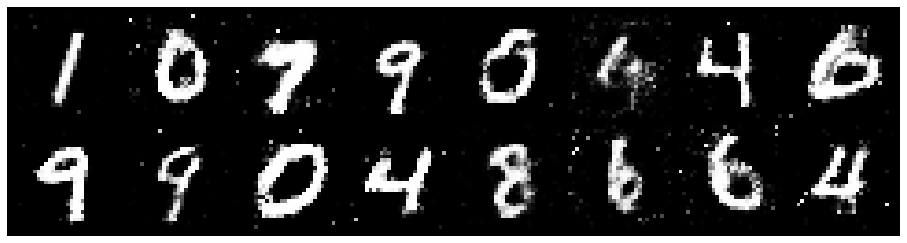

Epoch: [49/50], Batch Num: [300/600]
Discriminator Loss: 1.1117, Generator Loss: 1.0408
D(x): 0.6382, D(G(z)): 0.3917


In [0]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 50

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train Discriminator
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            d_optimizer, real_data, fake_data
        )

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress every few batches
        if (n_batch) % 300 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )